# Project Title

## Overview

There are ~10,000 known species of birds in the world today. While "only" ~150 birds are known to have gone extinct, over 1,200 species are currently globally threatened. Fortunately, we have more data on birds than ever before. After decades of research and recent crowdsourcing of observations through Cornell's eBird (https://ebird.org/home), we now have extensive data on birds' diet, habitat, range, feeding strategy, and more. As organizations continue to ramp up conservation effots, putting this data to work can help us better understand which birds are most at risk and what the key drivers are.

## Business Problem

The World Ornithological Society (WOS) has contracted us to build a model to accurately predict a birds threatened status. In addition to accurately predictions, they are interested in understanding the key drivers of threatened status in order to more effectively drive their conservation efforts.

We will use machine learning techniques on bird data including diets, habitat, range, and other characteristics to make these predictions and determine key predictors. As such, our main deliverable is less the model itself and more the intuition behind its decision-making.

We will take a particular interest in minimizing false negatives, i.e., where our model has not predicted a bird is threatened, when in reality it is. Mis-identifying a bird as "not threatened" is the worst case scenario for the WOS. False positives on the other hand are not particularly impactful. The "worst" case here is a slightly misguided conservation approach, which will have minimal harm. E.g., conservation efforts like protecting habitat and reducing pollution are still impactful even if theyy slightly miss the mark.

In our model, we will focus first on accuracy, then on tuning the model to minimize false negatives.

In [1]:
# SKLearn imports

# Processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, \
FunctionTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

# Scoring
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, \
plot_confusion_matrix, confusion_matrix

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [2]:
# Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Set style
plt.style.use('seaborn')

In [4]:
# Utility import

from util import evaluate_model, high_corr

## Data Understanding

The data was concatenated from two different sources. 
- The first source is a research paper published in the Ecological Society of America. For most bird species, the researchers collected diet information, foraging (feeding) strategy, and other characteristics about the bird (weight, nocturnal, passerine)
- The second was BirdLife.org, a non profit focused on bird conservation. Their data zone includes information on bird habitat, region, and the nature of the threat these species face (e.g., agriculture, climate change, etc).
- The two sources were concatenated on Scientific or English name

Target variable:
- The target is threatened status from BirdLife.org (they in turn pull this information from IUCN, which maintains threatened status information across all animals, not just birds).
- They consider species that are vulnerable, endangered, and critically endangered as being "globally threatened". This forms the bin for our target variable
- We intend to use most of the data, and even engineer some additional categories based on intuition. We will ignore several extraneous "object" columns such as "source" and "entered by" (useful information, but can't help a predictive model)

Data Cleaning:

- Fortunately, the main columns we intend to use don't require extensive cleaning (there are no nulls for example), but there will be some outliers to remove and normalization steps to take if we use a linear model

In [5]:
# Update Pandas settings for printing dataframes

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [6]:
# Read in data

df_birds = pd.read_csv('../../data/birds_withrange.csv', low_memory=False)

In [7]:
# Drop duplicate name and scientific name columns
df_birds.drop(columns=['English name_x', 'English name_y', 'Scientific Name'], axis=1, inplace=True)

df_birds.head()

,SpecID,PassNonPass,IOCOrder,BLFamilyLatin,BLFamilyEnglish,BLFamSequID,Taxo,Scientific,English,Diet-Inv,Diet-Vend,Diet-Vect,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,Diet-5Cat,Diet-Source,Diet-Certainty,Diet-EnteredBy,ForStrat-watbelowsurf,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,PelagicSpecialist,ForStrat-Source,ForStrat-SpecLevel,ForStrat-EnteredBy,Nocturnal,BodyMass-Value,BodyMass-Source,BodyMass-SpecLevel,BodyMass-Comment,Record-Comment,Family,Global IUCN Red List Category,endemic_breeding,migratory,africa,antarctica,asia,australasia,caribbean,central_amer,central_asia,europe,high_seas,mid_east,north_amer,oceania,south_amer,agriculture_threat,biological_threat,climate_change_threat,energy_mining_threat,geological_threat,human_intrusions_threat,natural_systems_threat,pollution_threat,res_comm_dev_threat,transportation_threat,invasive_threat,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland,breeding_range
0,37.00,Nonpasseriformes,Rheiformes,Rheidae,Rheas,3.00,BL3,Rhea americana,Greater Rhea,20.00,10.00,10.00,0.00,0.00,0.00,20.00,0.00,20.00,20.00,Omnivore,Ref_1,A,Jennifer,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,Ref_1,1.00,Jessica,0.00,23000.00,Dunning08,1.00,NaN,NaN,Rheidae (Rheas),NT,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,SA
1,38.00,Nonpasseriformes,Rheiformes,Rheidae,Rheas,3.00,BL3,Rhea pennata,Lesser Rhea,20.00,0.00,0.00,0.00,10.00,0.00,0.00,0.00,30.00,40.00,PlantSeed,Ref_1,A,Jennifer,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,Ref_1,1.00,Jessica,0.00,23900.00,Dunning08,1.00,NaN,NaN,Rheidae (Rheas),LC,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,SA
2,45.00,Nonpasseriformes,Casuariiformes,Casuariidae,Cassowaries,4.00,BL3,Casuarius casuarius,Southern Cassowary,10.00,0.00,0.00,0.00,10.00,0.00,80.00,0.00,0.00,0.00,FruiNect,Ref_1,A,Jennifer,0.00,0.00,80.00,20.00,0.00,0.00,0.00,0.00,Ref_1,1.00,Jessica,0.00,44000.00,Dunning08,1.00,NaN,NaN,"Casuariidae (Cassowaries, Emus)",LC,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,AU
3,46.00,Nonpasseriformes,Casuariiformes,Casuariidae,Cassowaries,4.00,BL3,Casuarius bennetti,Dwarf Cassowary,10.00,0.00,0.00,0.00,10.00,0.00,80.00,0.00,0.00,0.00,FruiNect,Ref_1,B,Jennifer,0.00,0.00,80.00,20.00,0.00,0.00,0.00,0.00,Ref_1,1.00,Jessica,0.00,34999.99,Dunning08,1.00,NaN,NaN,"Casuariidae (Cassowaries, Emus)",LC,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,AU
4,47.00,Nonpasseriformes,Casuariiformes,Casuariidae,Cassowaries,4.00,BL3,Casuarius unappendiculatus,Northern Cassowary,20.00,0.00,0.00,0.00,10.00,0.00,60.00,0.00,0.00,10.00,FruiNect,Ref_1,A,Jennifer,0.00,0.00,80.00,20.00,0.00,0.00,0.00,0.00,Ref_1,1.00,Jessica,0.00,46073.85,Dunning08,1.00,NaN,NaN,"Casuariidae (Cassowaries, Emus)",LC,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,AU


In [7]:
# This is the column that is throwing the mixed type error when reading in. 
# We won't be using it anyway so it's fine.

df_birds.columns.get_loc('Record-Comment')

39

In [8]:
df_birds['Global IUCN Red List Category'].value_counts()

LC        7448
NT         859
VU         685
EN         376
CR         167
DD          41
CR(PE)      11
EW           5
EX           5
Name: Global IUCN Red List Category, dtype: int64

In [9]:
df_birds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9597 entries, 0 to 9596
Data columns (total 84 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SpecID                         9597 non-null   float64
 1   PassNonPass                    9597 non-null   object 
 2   IOCOrder                       9597 non-null   object 
 3   BLFamilyLatin                  9597 non-null   object 
 4   BLFamilyEnglish                9597 non-null   object 
 5   BLFamSequID                    9597 non-null   float64
 6   Taxo                           9597 non-null   object 
 7   Scientific                     9597 non-null   object 
 8   English                        9597 non-null   object 
 9   Diet-Inv                       9597 non-null   float64
 10  Diet-Vend                      9597 non-null   float64
 11  Diet-Vect                      9597 non-null   float64
 12  Diet-Vfish                     9597 non-null   f

In [10]:
df_birds.describe()

,SpecID,BLFamSequID,Diet-Inv,Diet-Vend,Diet-Vect,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,ForStrat-watbelowsurf,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,PelagicSpecialist,ForStrat-SpecLevel,Nocturnal,BodyMass-Value,BodyMass-SpecLevel,endemic_breeding,migratory,africa,antarctica,asia,australasia,caribbean,central_amer,central_asia,europe,high_seas,mid_east,north_amer,oceania,south_amer,agriculture_threat,biological_threat,climate_change_threat,energy_mining_threat,geological_threat,human_intrusions_threat,natural_systems_threat,pollution_threat,res_comm_dev_threat,transportation_threat,invasive_threat,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland
count,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00
mean,7344.09,113.09,55.71,2.57,2.15,2.72,0.36,0.60,15.03,5.85,10.69,4.33,2.54,4.48,31.72,23.60,23.53,12.08,2.03,0.03,0.97,0.03,273.31,0.92,0.26,0.18,0.23,0.01,0.31,0.13,0.08,0.12,0.06,0.05,0.00,0.06,0.13,0.03,0.33,0.20,0.21,0.11,0.05,0.00,0.03,0.08,0.05,0.06,0.04,0.09,0.03,0.35,0.00,0.02,0.57,0.16,0.00,0.04,0.04,0.04,0.02,0.04,0.15,0.30,0.16
std,4654.52,54.64,37.12,12.07,7.67,12.43,3.80,5.44,25.63,19.21,21.77,13.23,14.13,17.00,37.81,25.83,26.19,21.62,10.78,0.17,0.18,0.18,1643.51,0.28,0.44,0.39,0.42,0.10,0.46,0.34,0.27,0.32,0.23,0.23,0.06,0.24,0.33,0.18,0.47,0.40,0.41,0.32,0.21,0.07,0.18,0.27,0.21,0.24,0.19,0.29,0.17,0.48,0.06,0.13,0.50,0.37,0.02,0.19,0.19,0.20,0.13,0.19,0.35,0.46,0.37
min,28.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.90,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3434.00,68.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,15.16,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,6961.00,109.00,60.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00,20.00,20.00,0.00,0.00,0.00,1.00,0.00,36.23,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,10829.00,163.00,100.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00,10.00,0.00,0.00,0.00,60.00,40.00,40.00,20.00,0.00,0.00,1.00,0.00,127.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
max,20107.00,194.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,1.00,1.00,1.00,111000.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [11]:
# Looking at diet and foraging strategies specifically. 
# If we're using a linear model, will need to remove one of these columns from each
# Looking at correlations between the diet columns. Leaning towards removing Diet-Vect.
# Also will remove ForStrat-watbelowsurf as that's the least correlated with Diet-Vect

foraging_cols = ['ForStrat-watbelowsurf', 'ForStrat-wataroundsurf', 'ForStrat-ground', 'ForStrat-understory',
                'ForStrat-midhigh', 'ForStrat-canopy', 'ForStrat-aerial']

diet_cols = ['Diet-Inv', 'Diet-Vend', 'Diet-Vect', 'Diet-Vfish', 'Diet-Vunk', 'Diet-Scav', 'Diet-Fruit',
             'Diet-Nect', 'Diet-Seed', 'Diet-PlantO']

foraging = df_birds[foraging_cols + ['Diet-Vect']]
diet = df_birds[diet_cols]

display(foraging.corr())
display(diet.corr())

,ForStrat-watbelowsurf,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,Diet-Vect
ForStrat-watbelowsurf,1.00,0.12,-0.14,-0.16,-0.16,-0.10,-0.03,-0.01
ForStrat-wataroundsurf,0.12,1.00,-0.08,-0.23,-0.23,-0.15,-0.05,0.08
ForStrat-ground,-0.14,-0.08,1.00,-0.32,-0.61,-0.41,-0.13,0.12
ForStrat-understory,-0.16,-0.23,-0.32,1.00,-0.02,-0.28,-0.11,-0.09
ForStrat-midhigh,-0.16,-0.23,-0.61,-0.02,1.00,0.19,-0.07,-0.08
ForStrat-canopy,-0.10,-0.15,-0.41,-0.28,0.19,1.00,-0.00,-0.07
ForStrat-aerial,-0.03,-0.05,-0.13,-0.11,-0.07,-0.00,1.00,-0.01
Diet-Vect,-0.01,0.08,0.12,-0.09,-0.08,-0.07,-0.01,1.00


,Diet-Inv,Diet-Vend,Diet-Vect,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO
Diet-Inv,1.00,-0.21,-0.12,-0.16,-0.04,-0.12,-0.48,-0.29,-0.41,-0.32
Diet-Vend,-0.21,1.00,0.29,-0.00,-0.01,0.07,-0.11,-0.06,-0.09,-0.06
Diet-Vect,-0.12,0.29,1.00,0.06,-0.01,0.04,-0.11,-0.08,-0.11,-0.06
Diet-Vfish,-0.16,-0.00,0.06,1.00,0.01,0.07,-0.13,-0.07,-0.10,-0.05
Diet-Vunk,-0.04,-0.01,-0.01,0.01,1.00,0.00,-0.03,-0.03,-0.04,-0.01
Diet-Scav,-0.12,0.07,0.04,0.07,0.00,1.00,-0.05,-0.03,-0.04,-0.03
Diet-Fruit,-0.48,-0.11,-0.11,-0.13,-0.03,-0.05,1.00,-0.09,-0.08,-0.02
Diet-Nect,-0.29,-0.06,-0.08,-0.07,-0.03,-0.03,-0.09,1.00,-0.13,-0.06
Diet-Seed,-0.41,-0.09,-0.11,-0.10,-0.04,-0.04,-0.08,-0.13,1.00,0.11
Diet-PlantO,-0.32,-0.06,-0.06,-0.05,-0.01,-0.03,-0.02,-0.06,0.11,1.00


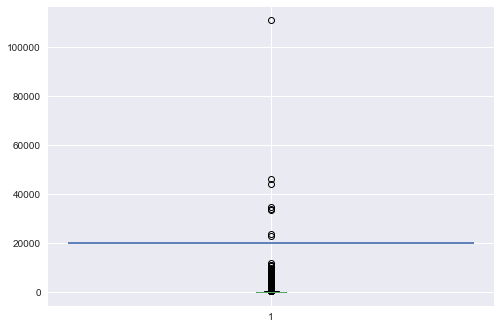

In [12]:
# Plot body weight
# Notes: appears to be a few outliers here above 20,000 grams

plt.boxplot(df_birds['BodyMass-Value']);
plt.hlines(20000, xmin=0, xmax=2);

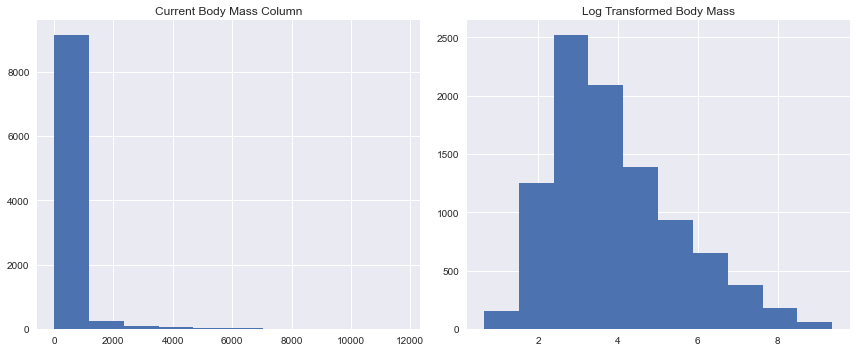

In [13]:
# Log transforming BodyMass significantly improves normalcy

fig, ax = plt.subplots(ncols=2, figsize=(12,5))

ax[0].hist(df_birds[df_birds['BodyMass-Value'] < 20000]['BodyMass-Value'])
ax[0].set_title('Current Body Mass Column')

ax[1].hist(np.log(df_birds[df_birds['BodyMass-Value'] < 20000]['BodyMass-Value']))
ax[1].set_title('Log Transformed Body Mass')

plt.tight_layout();

In [14]:
# Googled each of these and the weights are actually reasonable. The biggest 'outlier' is an ostrich.
# Excluding these from final analysis on the basis that these are large, flightless birds.
# Also, none of them are 

weight_outliers = df_birds[df_birds['BodyMass-Value'] > 20000][['English', 'BodyMass-Value', 'Global IUCN Red List Category']]

weight_outliers

,English,BodyMass-Value,Global IUCN Red List Category
0,Greater Rhea,23000.00,NT
1,Lesser Rhea,23900.00,LC
2,Southern Cassowary,44000.00,LC
3,Dwarf Cassowary,34999.99,LC
4,Northern Cassowary,46073.85,LC
3240,Emperor Penguin,33569.33,NT
8509,Ostrich,111000.00,LC
8510,Emu,34093.25,LC


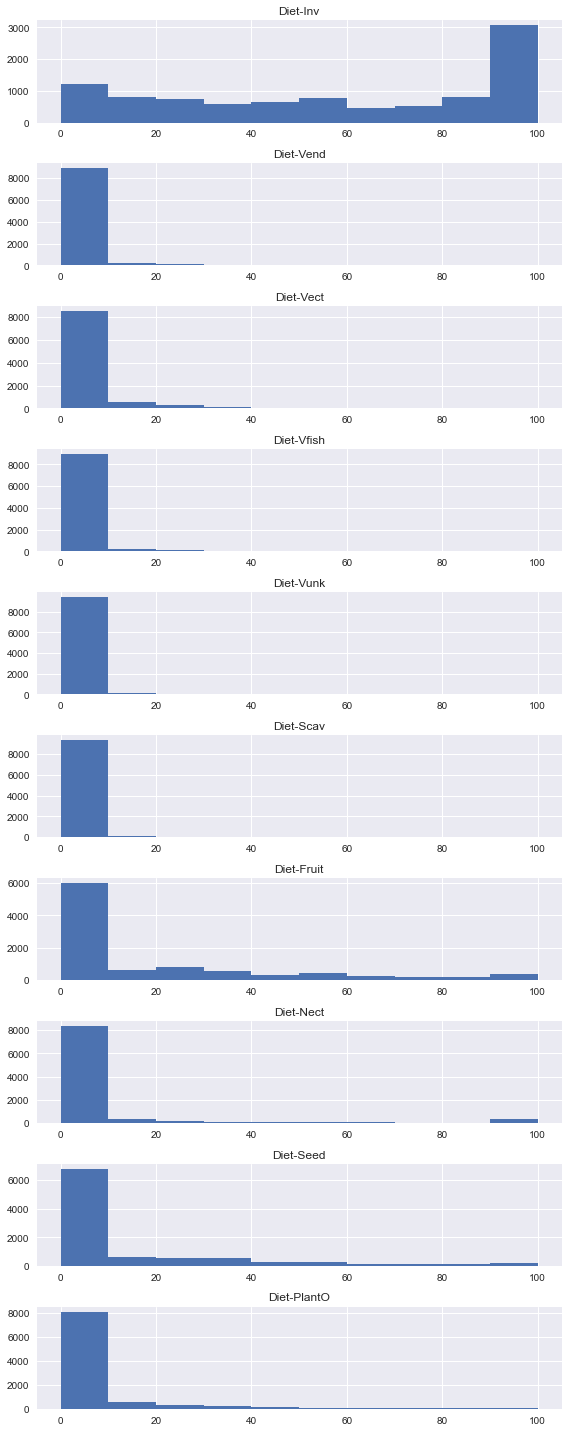

In [15]:
# Check distribution of diet cols
# Comments: None of them appear to have a normal distribution. Will need some transformation if doing 
# a linear model. Log is not suitable because there are 0s so may need to use log1p

fig, ax = plt.subplots(nrows=len(diet_cols), figsize=(8,20))

for i, col in enumerate(diet_cols):
    ax[i].hist(df_birds[col])
    ax[i].set_title(col);

plt.tight_layout();

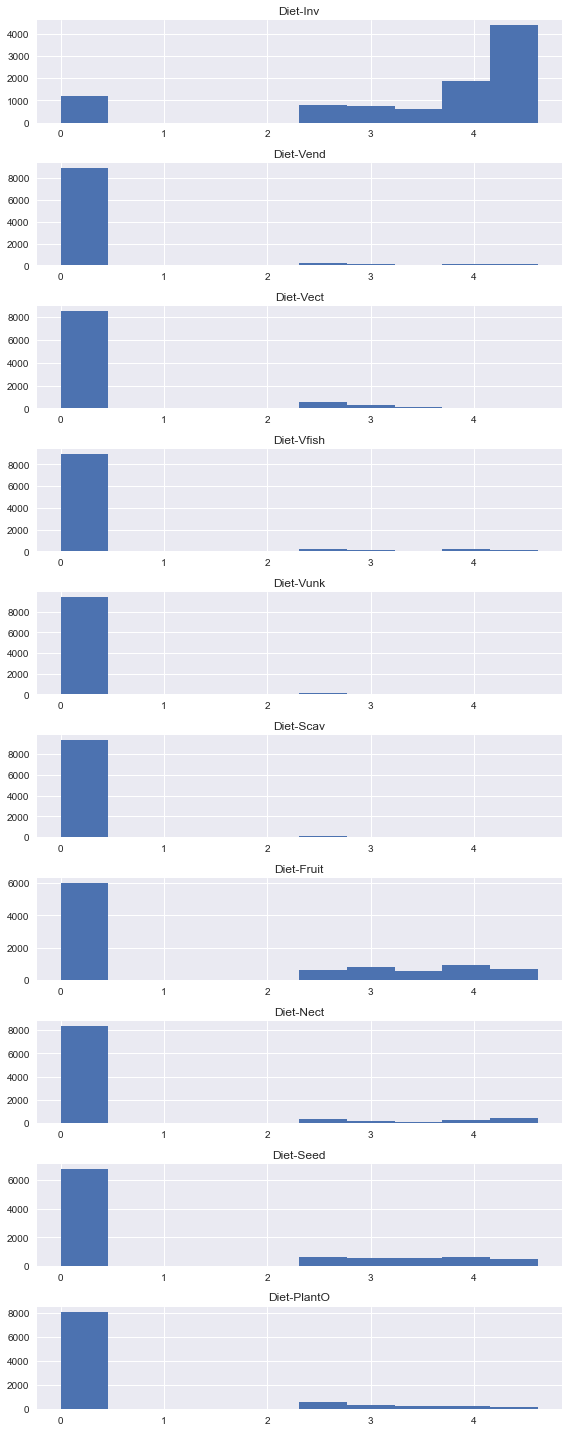

In [16]:
# Test log transforming. Note we need to add one because substantial number of 0s in the dataset
# Doesn't actually do all that much. May need to use a model that doesn't handle non-normality as well

fig, ax = plt.subplots(nrows=len(diet_cols), figsize=(8,20))

for i, col in enumerate(diet_cols):
    ax[i].hist(np.log1p(df_birds[col]))
    ax[i].set_title(col);

plt.tight_layout();

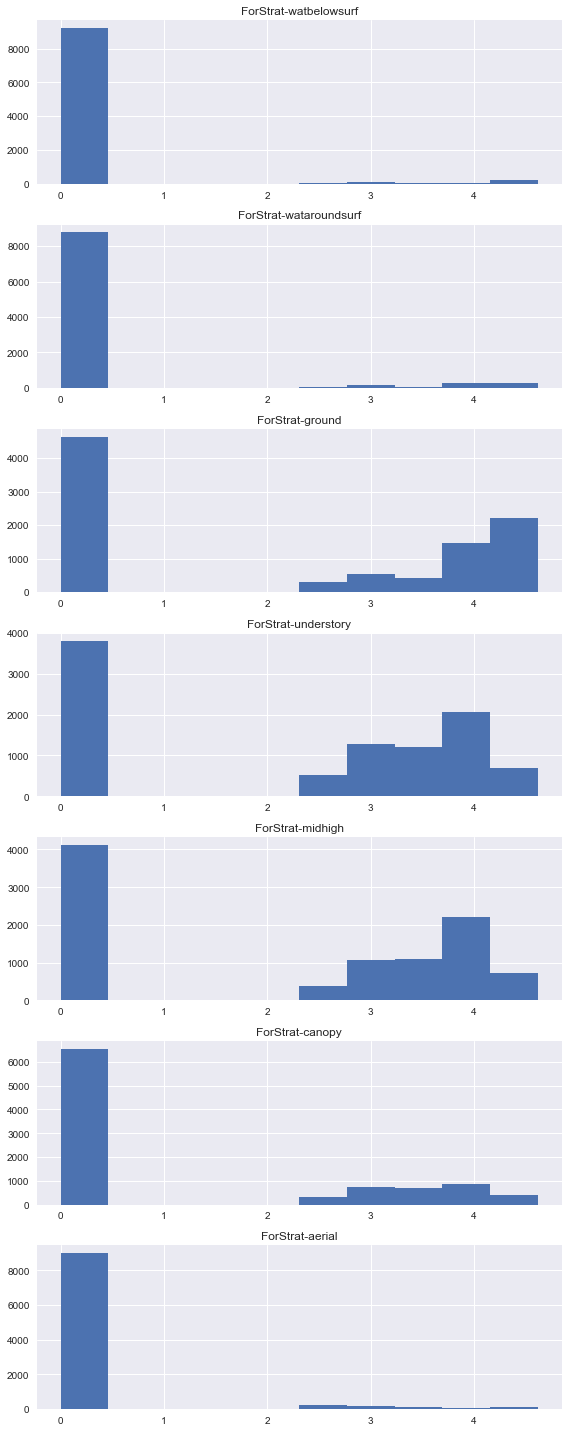

In [17]:
# Check distribution of foraging columns after log transforming

fig, ax = plt.subplots(nrows=len(foraging_cols), figsize=(8,20))

for i, col in enumerate(foraging_cols):
    ax[i].hist(np.log1p(df_birds[col]))
    ax[i].set_title(col);

plt.tight_layout();

## Data Preparation

- Outliers: filtered for weight below 20,000. Birds above this weight are all large, flightless birds (think: Ostrich). None of them are Threatened. Our model will not be suitable for predicting birds above this weight
- There are a few Extinct birds that have snuck in to the final dataset. We are exluding these species
- One hot encode the Passerine and the Diet-5Cat columns

In [18]:
# Remove outliers: all birds with a weight over 20K grams

weight_threshold = 20000
df_clean = df_birds.copy()

df_clean = df_clean[df_clean['BodyMass-Value'] < weight_threshold]

In [19]:
# Create the target variable

df_clean['threatened'] = 0

df_clean.loc[(df_clean['Global IUCN Red List Category'] == 'VU') |
             (df_clean['Global IUCN Red List Category'] == 'EN') |
             (df_clean['Global IUCN Red List Category'] == 'CR') |
             (df_clean['Global IUCN Red List Category'] == 'CR(PE)'), 'threatened'] = 1

In [63]:
df_clean = df_clean[(df_clean['Global IUCN Red List Category'] != 'EX') &
                    (df_clean['Global IUCN Red List Category'] != 'EW') &
                    (df_clean['Global IUCN Red List Category'] != 'DD')]

In [21]:
# One hot encode Passerine and Diet 5 Category

to_encode = df_clean[['PassNonPass', 'Diet-5Cat']]

ohe = OneHotEncoder(drop='first', categories='auto', sparse=False)

cat_transformed = ohe.fit_transform(to_encode)

df_ohe = pd.DataFrame(cat_transformed, columns=ohe.get_feature_names(), index=df_clean.index)

#### Data Engineering

The below is based partly off intuition and seeing which columns have been most impactful in some of our models.

- Add columns for 'number of threats', 'number of habitats', and 'number of regions'. Idea is that quantity of threats faced could have predictive value. Also species that don't rely on a single habitat could be more resilient.
- Add a column for 'marine' habitat. Then create an interaction between that and (1) pollution threat and (2) climate change threat. The idea is that these species might be more sensitive to these types of threats.
- We found that agriculture and invasive species were one of the better decision tree predictors. We created new columns for the interaction of agricultural threat and num_habitats = 1 (and same for invasive species). The idea is to focus in on species that rely only on a single habitat, which also faces the most impactful threat.

In [22]:
# Identify relevant columns

threats = ['agriculture_threat', 'biological_threat', 'climate_change_threat', 'energy_mining_threat',
          'geological_threat', 'human_intrusions_threat', 'natural_systems_threat', 'pollution_threat', 
          'res_comm_dev_threat', 'transportation_threat', 'invasive_threat']

habitats = ['artificial_aquatic', 'artificial_terrestrial', 'caves_subterranean', 'desert', 'forest', 'grassland',
           'introduced_vegetation', 'marine_coastal_supratidal', 'marine_intertidal', 'marine_neritic', 
            'marine_oceanic', 'rocky_areas', 'savanna', 'shrubland', 'wetlands_inland']

regions = ['africa', 'antarctica', 'asia', 'australasia', 'caribbean', 'central_amer', 'central_asia',
          'europe', 'high_seas', 'mid_east', 'north_amer', 'oceania', 'south_amer']

In [23]:
# Add number of threats, habitats, and regions

df_clean['num_threats'] = df_clean[threats].sum(axis=1)
df_clean['num_habitats'] = df_clean[habitats].sum(axis=1)
df_clean['num_regions'] = df_clean[regions].sum(axis=1)

In [24]:
# Create interaction of marine habitat and pollution / climate change

df_clean['marine_hab'] = 0
df_clean.loc[(df_clean['marine_coastal_supratidal'] == 1) |
             (df_clean['marine_intertidal'] == 1) |
             (df_clean['marine_neritic'] == 1) |
             (df_clean['marine_oceanic'] == 1), 'marine_hab'] = 1

df_clean['marine_x_pollution'] = df_clean['marine_hab'] * df_clean['pollution_threat']
df_clean['marine_x_climatechg'] = df_clean['marine_hab'] * df_clean['climate_change_threat']

In [25]:
# Add instance where species faces both an agriculture / invasive threat and only has one habitat.

df_clean['ag+habitat'] = 0 
df_clean.loc[(df_clean['agriculture_threat']==1) & (df_clean['num_habitats']==1), 'ag+habitat'] = 1

df_clean['inv+habitat'] = 0 
df_clean.loc[(df_clean['invasive_threat']==1) & (df_clean['num_habitats']==1), 'inv+habitat'] = 1

df_clean['all+habitat'] = 0 
df_clean.loc[(df_clean['num_threats']>=3) & (df_clean['num_habitats']==1), 'inv+habitat'] = 1

#### Variable removal (for linear models only)

- Decided to remove Diet-Vunk and ForStrat-watbelowsurf
- Removed Diet-Vunk because it's reasonably positively correlated with Vend and has "middle of the road" representation in the data
- Decided to remove ForStrat-watbelowsurf because that's the least correlated with Diet-Vunk
- Removed marine habitat, pollution threat, and climate change because of new interaction variables we created above

In [26]:
# Create X and Y variables

to_remove = ['SpecID', 'PassNonPass', 'IOCOrder', 'BLFamilyLatin', 'BLFamilyEnglish', 'BLFamSequID', 'Taxo',
            'Scientific', 'English', 'Diet-5Cat', 'Diet-Source', 'Diet-Certainty', 'Diet-EnteredBy', 
            'BodyMass-Source', 'BodyMass-SpecLevel', 'BodyMass-Comment', 'Record-Comment', 'Family',
            'Global IUCN Red List Category', 'breeding_range', 'threatened', 'ForStrat-Source', 
             'ForStrat-EnteredBy', 'Diet-Vect', 'ForStrat-watbelowsurf', 'marine_hab', 'pollution_threat',
            'climate_change_threat', 'ForStrat-SpecLevel']

X = df_clean.drop(columns=to_remove, axis=1)
X = pd.concat([X, df_ohe], axis=1)

y = df_clean['threatened']

In [27]:
# Perform test train split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [28]:
X_train.head()

,Diet-Inv,Diet-Vend,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,PelagicSpecialist,Nocturnal,BodyMass-Value,endemic_breeding,migratory,africa,antarctica,asia,australasia,caribbean,central_amer,central_asia,europe,high_seas,mid_east,north_amer,oceania,south_amer,agriculture_threat,biological_threat,energy_mining_threat,geological_threat,human_intrusions_threat,natural_systems_threat,res_comm_dev_threat,transportation_threat,invasive_threat,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland,num_threats,num_habitats,num_regions,marine_x_pollution,marine_x_climatechg,ag+habitat,inv+habitat,all+habitat,x0_Passeriformes,x1_Invertebrate,x1_Omnivore,x1_PlantSeed,x1_VertFishScav
2463,20.00,0.00,0.00,0.00,10.00,0.00,0.00,30.00,40.00,50.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,826.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,5.00,5.00,2.00,0.00,0.00,0,0,0,0.00,0.00,0.00,1.00,0.00
6564,70.00,0.00,0.00,0.00,0.00,10.00,0.00,10.00,10.00,0.00,50.00,50.00,0.00,0.00,0.00,0.00,0.00,78.64,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,3.00,2.00,1.00,0.00,0.00,0,0,0,1.00,1.00,0.00,0.00,0.00
957,60.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,90.00,10.00,0.00,0.00,0.00,0.00,0.00,97.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0,0,0,0.00,1.00,0.00,0.00,0.00
7988,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,30.00,70.00,0.00,0.00,0.00,0.00,0.00,9.80,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0,1.00,0.00,0.00,1.00,0.00
2088,0.00,0.00,0.00,0.00,0.00,80.00,0.00,20.00,0.00,0.00,0.00,0.00,50.00,50.00,0.00,0.00,0.00,125.93,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,3.00,1.00,0.00,0.00,0,0,0,0.00,0.00,0.00,0.00,0.00


### Multicollinearity

- Check for high multicollinearity in the train set. Doing this after the split to avoid data leakage
- Conclusions:
    - Remove OHE x1_Invertebrate column
    - Remove Europe as that seems to be most common denominator among region flags
    - Remove OHE x1_PlantSeed column
    - Combine biological / agriculture threat into one interaction column. bio_or_ag_threat
    - Combine marine_neritic and marine_oceanic

In [29]:
hc = high_corr(X_train, 0.6)

hc

,cc
pairs,
"(Diet-Inv, Diet-Inv)",1.00
"(x1_Invertebrate, Diet-Inv)",0.90
"(biological_threat, num_threats)",0.78
"(num_threats, agriculture_threat)",0.76
"(central_asia, europe)",0.71
"(Diet-Seed, x1_PlantSeed)",0.71
"(europe, mid_east)",0.71
"(ag+habitat, inv+habitat)",0.70
"(biological_threat, agriculture_threat)",0.69


In [30]:
# Fix collinearity issues described above

# First on X_train
X_train['bio_or_ag_threat'] = 0
X_train.loc[(X_train['biological_threat'] == 1) |
            (X_train['agriculture_threat'] == 1), 'bio_or_ag_threat'] = 1

X_train['marine_ner_oceanic'] = 0
X_train.loc[(X_train['marine_neritic'] == 1) |
            (X_train['marine_oceanic'] == 1), 'marine_ner_oceanic'] = 1

X_train = X_train.drop(columns=['x1_Invertebrate', 'x1_PlantSeed', 'europe', 'marine_neritic', 
                                'marine_oceanic', 'biological_threat', 'agriculture_threat'], axis=1)


# Then on X_test
X_test['bio_or_ag_threat'] = 0
X_test.loc[(X_test['biological_threat'] == 1) |
           (X_test['agriculture_threat'] == 1), 'bio_or_ag_threat'] = 1

X_test['marine_ner_oceanic'] = 0
X_test.loc[(X_test['marine_neritic'] == 1) |
           (X_test['marine_oceanic'] == 1), 'marine_ner_oceanic'] = 1

X_test = X_test.drop(columns=['x1_Invertebrate', 'x1_PlantSeed', 'europe', 'marine_neritic', 
                              'marine_oceanic', 'biological_threat', 'agriculture_threat'], axis=1)

<ipython-input-30-f5a5da9be7c7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['bio_or_ag_threat'] = 0
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-30-f5a5da9be7c7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

### Pipeline Set Up:

- We have no nulls to take care of
- Log transform size
- Log1p transform the diet and foraging columns
- Use min max scaler to standardize the remaining columns

In [31]:
# Identify relevant columns for each transformation

log_t_cols = ['BodyMass-Value']
temp = diet_cols + foraging_cols
removed = ['Diet-Vect', 'ForStrat-watbelowsurf', 'marine_hab', 'pollution_threat', 'climate_change_threat']
log_1p_cols = [col for col in temp if col not in removed]

min_max_cols = [x for x in X_train.columns if x not in log_t_cols + log_1p_cols]

In [32]:
# Create Pipelines for preprocessing

log_transformer = Pipeline(steps=[
        ('log_transformer', FunctionTransformer(np.log))])

log_1ptransformer = Pipeline(steps=[
        ('log_1ptransformer', FunctionTransformer(np.log1p))
])

min_max = Pipeline(steps=[
        ('min_max_scalar', MinMaxScaler())])

In [33]:
# Create preprocessor using column transformer

preprocessor = ColumnTransformer(transformers=[
                                ('log', log_transformer, log_t_cols),
                                ('log1p', log_1ptransformer, log_1p_cols), 
                                ('min_max', min_max, min_max_cols)])

## Modeling

Modeling will take an iterative approach. Since we want our model to be interpretable, we will eliminate KNN and Bayes as possibilities. That leaves logistic regression and various decision tree approaches as the potential final model

### Dummy model

- Running below to have a baseline to compare against
- Metrics based on selecting most common outcome

Accuracy: 0.8707
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC: nan


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


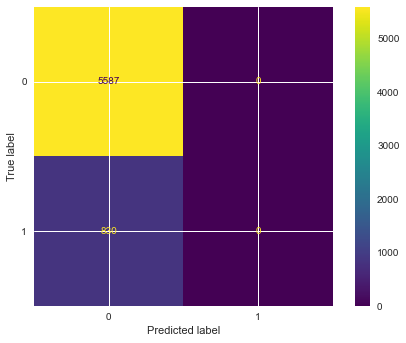

In [34]:
dc = DummyClassifier(random_state=42, strategy='most_frequent')

dc.fit(X_train, y_train)

acc, prec, rec, f1 = evaluate_model(dc, X_train, y_train, plot_cf=True)

### First simple model

- First simple logistic regression without any hyperparameter tuning or scaling
- Requires 4,000 steps to converge. Performs reasonably similarly across Train and Test
- Has only improve accuracy by 2-3 ppt
- More false negatives than false positives (hence lower recall)


In [35]:
# First logistic regression

simple_log = LogisticRegression(max_iter=10000, random_state=42)

simple_log.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [36]:
# Cross validation

simple_output = cross_validate(simple_log, X_train, y_train, cv=5, scoring=['accuracy', 'roc_auc'])

print(f"Accuracy: {simple_output['test_accuracy']}")
print(f"AUC {simple_output['test_roc_auc']}")

Accuracy: [0.90498442 0.91433022 0.92049883 0.90101325 0.89867498]
AUC [0.94666142 0.95676983 0.95101984 0.95148904 0.94376072]


Train results
Accuracy: 0.9121
Precision: 0.6847
Recall: 0.5940
F1 Score: 0.6361
ROC: 0.9559

Test results
Accuracy: 0.9070
Precision: 0.6648
Recall: 0.5672
F1 Score: 0.6121
ROC: 0.9550



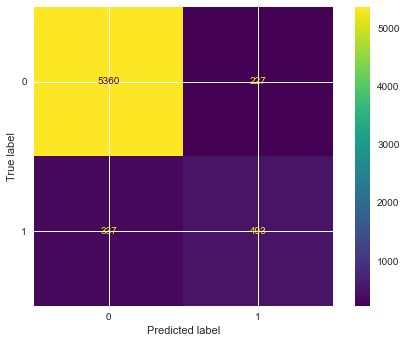

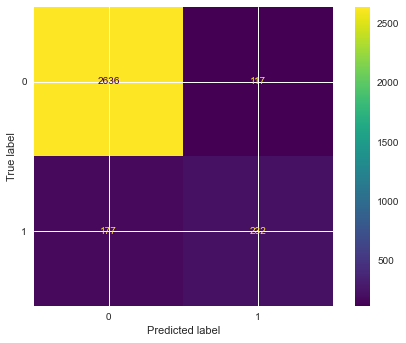

In [37]:
for i, item in enumerate([(X_train, y_train), (X_test, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(simple_log, item[0], item[1], plot_cf=True)
    print('')

### Model 2: Additional data processing
- Apply min max scalar
- Log transform weight column
- Try class_weights = balanced in the log reg

Results:
- The accuracy has gotten slightly worse, but interestingly, this approach has materially reduced false negatives

In [36]:
log_reg = Pipeline(steps=[
                  ('preprocessor', preprocessor),
                  ('log_clf', LogisticRegression(random_state=42, class_weight='balanced', max_iter=5000))
])

log_reg.fit(X_train, y_train)

output2 = cross_validate(log_reg, X_train, y_train, cv=3, scoring=['accuracy', 'roc_auc'])

output2['test_accuracy']

array([0.87237027, 0.88312295, 0.8798504 ])

Train results
Accuracy: 0.8830
Precision: 0.5261
Recall: 0.9602
F1 Score: 0.6797
ROC: 0.9543

Test results
Accuracy: 0.8903
Precision: 0.5432
Recall: 0.9535
F1 Score: 0.6921
ROC: 0.9565



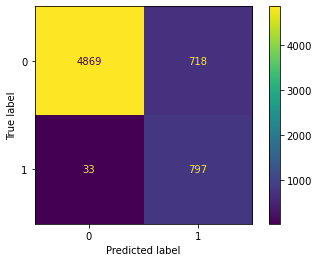

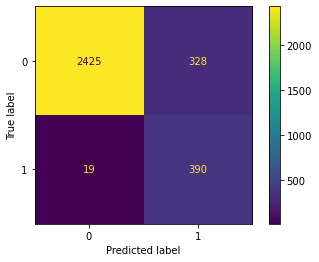

In [37]:
for i, item in enumerate([(X_train, y_train), (X_test, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(log_reg, item[0], item[1], plot_cf=True)
    print('')

### Model 3: Search for Logistic Regression best model parameters

- Changes to test
    - Class weights: balanced vs. None
    - L2 vs. L1 penalty
    - Various penalization strengths

In [38]:
# Create log_reg2 Pipeline

log_reg2 = Pipeline(steps=[
                   ('preprocessor', preprocessor),
                   ('log_clf', LogisticRegression())
])

In [39]:
# Set up parameters for the logistic regression

weights = np.linspace(0.05, 0.95, 10)

log_param_grid = {
'log_clf__penalty': ['l1', 'l2'],
'log_clf__C': [0.01, 0.1, 1, 100, 1000],
'log_clf__class_weight': [{0: x, 1: 1.0-x} for x in weights],
'log_clf__max_iter': [10000],
'log_clf__random_state': [42]
}

In [40]:
log_grid_search = GridSearchCV(log_reg2, log_param_grid, return_train_score=True, cv=3)

# Fit to the data
log_grid_search.fit(X_train, y_train)

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('log',
                                                                         Pipeline(steps=[('log_transformer',
                                                                                          FunctionTransformer(func=<ufunc 'log'>))]),
                                                                         ['BodyMass-Value']),
                                                                        ('log1p',
                                                                         Pipeline(steps=[('log_1ptransformer',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                         ['Diet-Inv',
                                                                          'Diet-Vend',
      

In [41]:
# Return best params
# Best params are very close to what we had in the original model, but will double check to be sure

log_grid_search.best_params_

{'log_clf__C': 1000,
 'log_clf__class_weight': {0: 0.44999999999999996, 1: 0.55},
 'log_clf__max_iter': 10000,
 'log_clf__penalty': 'l2',
 'log_clf__random_state': 42}

In [42]:
log_reg_best_params = Pipeline(steps=[
                              ('preprocessor', preprocessor),
                              ('log_clf', LogisticRegression(random_state=42, class_weight={0: 0.45, 1: 0.55}, max_iter=10000, C=1000))
])

log_reg_best_params.fit(X_train, y_train)

output3 = cross_validate(log_reg_best_params, X_train, y_train, cv=3, scoring=['accuracy', 'roc_auc'])

output3['test_accuracy']

array([0.90556335, 0.91584853, 0.90229079])

Train results
Accuracy: 0.9137
Precision: 0.6679
Recall: 0.6614
F1 Score: 0.6646
ROC: 0.9564

Test results
Accuracy: 0.9118
Precision: 0.6667
Recall: 0.6357
F1 Score: 0.6508
ROC: 0.9548



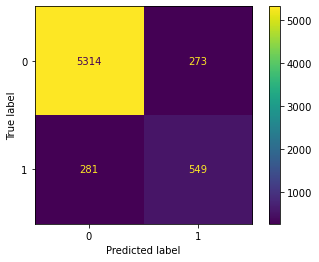

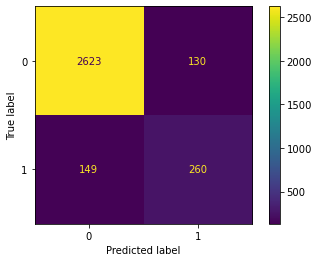

In [43]:
for i, item in enumerate([(X_train, y_train), (X_test, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(log_reg_best_params, item[0], item[1], plot_cf=True)
    print('')

#### Recursive feature selection

- Testing if we can simplify the feature subset a bit without sacrificing accuracy
- Conclusion: by limiting features to only those ranked 10th or higher, the model doesn't perform substantially worse, but we still have a concerning number of false negatives

In [40]:
X_train_preproc = pd.DataFrame(preprocessor.fit_transform(X_train), columns=X_train.columns)
X_test_preproc = pd.DataFrame(preprocessor.transform(X_test), columns=X_test.columns)

In [41]:
log_reg_feature_sel = LogisticRegression(random_state=42, class_weight={0: 0.45, 1: 0.55}, max_iter=10000, C=1000)

rfe = RFE(log_reg_feature_sel)

rfe.fit(X_train_preproc, y_train)

RFE(estimator=LogisticRegression(C=1000, class_weight={0: 0.45, 1: 0.55},
                                 max_iter=10000, random_state=42))

In [42]:
# Pull in only the features that were the ranked 10th or below

simple_cols = []
ranking_results = dict(zip(X_train_preproc.columns, rfe.ranking_))

ranking_threshold = 10

for key, value in ranking_results.items():
    if value <= ranking_threshold:
        simple_cols.append(key)
        
X_train_fs = X_train_preproc[simple_cols]
X_test_fs = X_test_preproc[simple_cols]

In [43]:
log_reg_feat_selec = LogisticRegression(random_state=42, class_weight=None, max_iter=10000, C=1000)

log_reg_feat_selec.fit(X_train_fs, y_train)

output4 = cross_validate(log_reg_feat_selec, X_train_fs, y_train, cv=5, scoring=['accuracy', 'roc_auc'])

output4['test_accuracy']

array([0.90965732, 0.9135514 , 0.91582229, 0.90646921, 0.89711613])

Train results
Accuracy: 0.9123
Precision: 0.6831
Recall: 0.6000
F1 Score: 0.6389
ROC: 0.9544

Test results
Accuracy: 0.9083
Precision: 0.6705
Recall: 0.5721
F1 Score: 0.6174
ROC: 0.9545



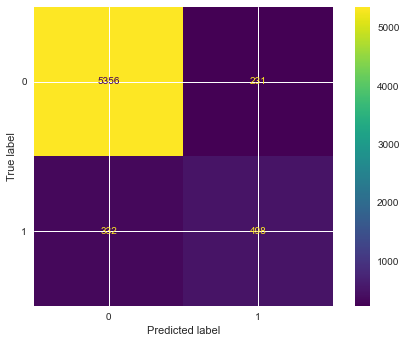

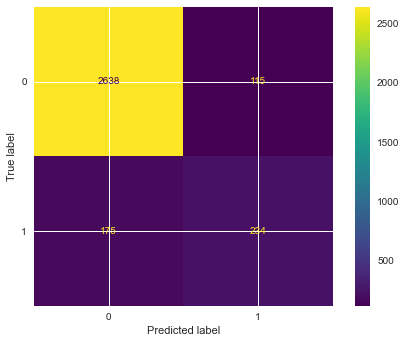

In [44]:
for i, item in enumerate([(X_train_fs, y_train), (X_test_fs, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(log_reg_feat_selec, item[0], item[1], plot_cf=True)
    print('')

### Adjust thresholds of simple feature model

- Use predict proba to adjust threshold for final model to attempt to minimize the false negative rate
- There is a tradeoff with accuracy, however. The sweet spot seems to be around 0.2-0.3
- Will test decision tree to see if we can't get higher accuracy while reducing false negatives

In [45]:
thresholds = np.linspace(0.1,0.5,5)

In [46]:
y_preds_proba = log_reg_feat_selec.predict_proba(X_test_fs)

for threshold in thresholds:
    y_preds = (y_preds_proba[:,1] >= threshold).astype('int')
    print(f"Threshold: {threshold}")
    print(f"Accuracy: {accuracy_score(y_test, y_preds)}")
    print(f"Recall: {recall_score(y_test, y_preds)}")
    display(confusion_matrix(y_test, y_preds))
    print("")

Threshold: 0.1
Accuracy: 0.8833017077798861
Recall: 0.9559902200488998


array([[2402,  351],
       [  18,  391]])


Threshold: 0.2
Accuracy: 0.8956356736242884
Recall: 0.8924205378973105


array([[2467,  286],
       [  44,  365]])


Threshold: 0.30000000000000004
Accuracy: 0.9025932953826692
Recall: 0.8068459657701712


array([[2524,  229],
       [  79,  330]])


Threshold: 0.4
Accuracy: 0.9117647058823529
Recall: 0.7017114914425427


array([[2596,  157],
       [ 122,  287]])


Threshold: 0.5
Accuracy: 0.9082858950031626
Recall: 0.5721271393643031


array([[2638,  115],
       [ 175,  234]])

### SMOTE

- Attempting to adjust class imbalance at the start using SMOTE and generating synthetic threatened samples
- Testing with the reduced columns from the feature selection output
- Materially reduces incidence of false negatives, but our accuracy suffers by a greater amount than we'd like

In [50]:
# Resample the train data using SMOTE

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train_fs, y_train) 

In [51]:
log_reg_resamp = LogisticRegression(random_state=42, max_iter=5000)

log_reg_resamp.fit(X_train_resampled, y_train_resampled)

output_resamp = cross_validate(log_reg_resamp, X_train_resampled, y_train_resampled, cv=5, scoring=['accuracy', 'roc_auc'])

output_resamp['test_accuracy']

array([0.90380313, 0.92527964, 0.91856823, 0.93064877, 0.91181737])

Train results
Accuracy: 0.8841
Precision: 0.5291
Recall: 0.9434
F1 Score: 0.6779
ROC: 0.9520

Test results
Accuracy: 0.8896
Precision: 0.5425
Recall: 0.9364
F1 Score: 0.6870
ROC: 0.9540



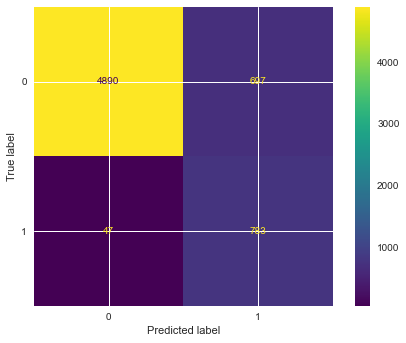

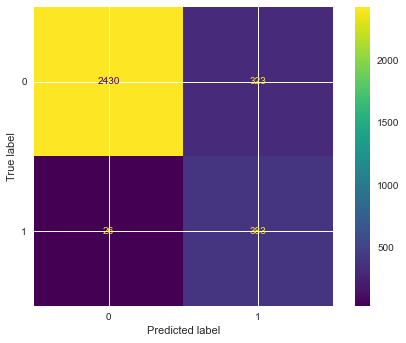

In [53]:
for i, item in enumerate([(X_train_fs, y_train), (X_test_fs, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(log_reg_resamp, item[0], item[1], plot_cf=True)
    print('')

### SMOTE grid search

- The model does a good enough job reducing false negatives that it's worth seeing if we can increase accuracy through parameter tuning
- Conclusion: hasn't returned parameters that are any different from default

In [630]:
log_reg_resamp = Pipeline(steps=[
                           ('preprocessor', preprocessor),
                           ('log_clf', LogisticRegression())
])

In [631]:
# Set up parameters for the logistic regression

weights = np.linspace(0.05, 0.95, 10)

SMOTE_grid = {
'log_clf__penalty': ['l1', 'l2'],
'log_clf__C': [0.01, 0.1, 1, 100, 1000],
'log_clf__max_iter': [10000],
'log_clf__random_state': [42],
'log_clf__solver': ['lbfgs', 'liblinear']
}

In [633]:
SMOTE_search = GridSearchCV(log_reg_resamp, SMOTE_grid, return_train_score=True, cv=5)

# Fit to the data
SMOTE_search.fit(X_train_resampled, y_train_resampled)

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

{'log_clf__C': 1000,
 'log_clf__max_iter': 10000,
 'log_clf__penalty': 'l2',
 'log_clf__random_state': 42,
 'log_clf__solver': 'lbfgs'}

In [634]:
# Print best parameters

SMOTE_search.best_params_

{'log_clf__C': 1000,
 'log_clf__max_iter': 10000,
 'log_clf__penalty': 'l2',
 'log_clf__random_state': 42,
 'log_clf__solver': 'lbfgs'}

### Random Forest

- Decision trees have proved to be decent predictors and can reduce the incidence of false negatives
- Hoping to improve the overall accuracy by utilizing random forests
- First model will use 100 estimators and a max depth of 10

In [56]:
# Re-do the train test split (multi-collinearity is less of an issue here so we want to bring some columns back)

to_remove = ['SpecID', 'PassNonPass', 'IOCOrder', 'BLFamilyLatin', 'BLFamilyEnglish', 'BLFamSequID', 'Taxo',
            'Scientific', 'English', 'Diet-5Cat', 'Diet-Source', 'Diet-Certainty', 'Diet-EnteredBy', 
            'BodyMass-Source', 'BodyMass-SpecLevel', 'BodyMass-Comment', 'Record-Comment', 'Family',
            'Global IUCN Red List Category', 'breeding_range', 'threatened', 'ForStrat-Source', 
             'ForStrat-EnteredBy']

X2 = df_clean.drop(columns=to_remove, axis=1)
X2 = pd.concat([X2, df_ohe], axis=1)

y2 = df_clean['threatened']

X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [57]:
simple_forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

simple_forest.fit(X_train_nl, y_train_nl)

RandomForestClassifier(max_depth=10, random_state=42)

Train results
Accuracy: 0.9688
Precision: 0.9189
Recall: 0.8325
F1 Score: 0.8736
ROC: nan

Test results
Accuracy: 0.9181
Precision: 0.7038
Recall: 0.6333
F1 Score: 0.6667
ROC: nan



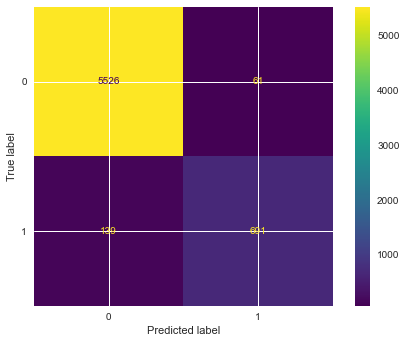

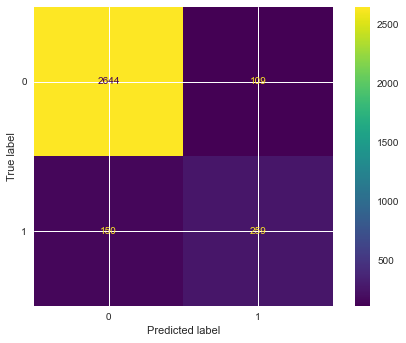

In [58]:
for i, item in enumerate([(X_train_nl, y_train_nl), (X_test_nl, y_test_nl)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(simple_forest, item[0], item[1], plot_cf=True)
    print('')

### RF Hyperparameter tuning
- Description of tuned features here

In [62]:
# Set up parameters for the Random Forest

rf_model = RandomForestClassifier(random_state=42)

weights = np.linspace(0.05, 0.95, 10)

rf_param_grid = {
'max_depth': [2, 3, 4, 5, 10, 15],
'max_features': list(range(10,25)),
'min_samples_split': [2, 3, 4],
'class_weight': [{0: x, 1: 1.0-x} for x in weights] + ['balanced']
}

In [330]:
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, return_train_score=True, cv=5, scoring='accuracy')

# Fit to the data
rf_grid_search.fit(X_train_nl, y_train_nl)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': [{0: 0.05, 1: 0.95},
                                          {0: 0.15, 1: 0.85},
                                          {0: 0.25, 1: 0.75},
                                          {0: 0.35, 1: 0.65},
                                          {0: 0.44999999999999996, 1: 0.55},
                                          {0: 0.5499999999999999,
                                           1: 0.45000000000000007},
                                          {0: 0.65, 1: 0.35},
                                          {0: 0.75, 1: 0.25},
                                          {0: 0.85, 1: 0.15000000000000002},
                                          {0: 0.95, 1: 0.050000000000000044}],
                         'max_depth': [2, 3, 4, 5, 10, 15],
                         'max_features': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                          19, 20, 21,

In [331]:
rf_grid_search.best_params_

{'class_weight': {0: 0.5499999999999999, 1: 0.45000000000000007},
 'max_depth': 10,
 'max_features': 16,
 'min_samples_split': 4}

In [59]:
rf_best_params = RandomForestClassifier(random_state=42, max_depth=10, min_samples_split=4, max_features=16,
                                       class_weight={0: 0.55, 1: 0.45})

rf_best_params.fit(X_train_nl, y_train_nl)

RandomForestClassifier(class_weight={0: 0.55, 1: 0.45}, max_depth=10,
                       max_features=16, min_samples_split=4, random_state=42)

Train results
Accuracy: 0.9727
Precision: 0.9456
Recall: 0.8373
F1 Score: 0.8882
ROC: nan

Test results
Accuracy: 0.9184
Precision: 0.7176
Recall: 0.6088
F1 Score: 0.6587
ROC: nan



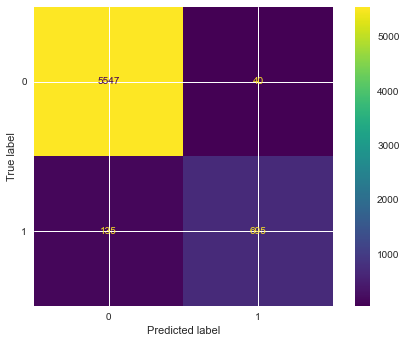

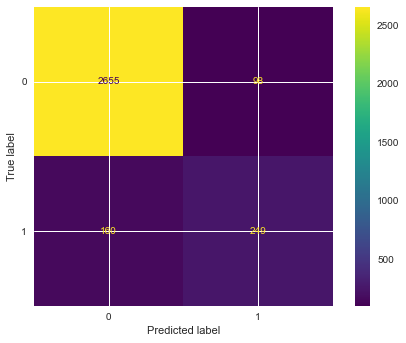

In [60]:
for i, item in enumerate([(X_train_nl, y_train_nl), (X_test_nl, y_test_nl)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(rf_best_params, item[0], item[1], plot_cf=True)
    print('')

#### RF Grid Search, optimizing on Recall

In [61]:
rf_grid_search2 = GridSearchCV(rf_model, rf_param_grid, return_train_score=True, cv=5, scoring='recall')

# Fit to the data
rf_grid_search2.fit(X_train_nl, y_train_nl)

NameError: name 'rf_model' is not defined

In [644]:
rf_grid_search2.best_params_

{'class_weight': {0: 0.05, 1: 0.95},
 'max_depth': 2,
 'max_features': 10,
 'min_samples_split': 2}

In [139]:
rf_best_params2 = RandomForestClassifier(n_estimators=100, max_depth=12, max_features=15, 
                                         min_samples_split=4, random_state=42, class_weight='balanced')
# {0: 0.05, 1: 0.95}

rf_best_params2.fit(X_train_nl, y_train_nl)

RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=15,
                       min_samples_split=4, random_state=42)

Train results
Accuracy: 0.9310
Precision: 0.6520
Recall: 1.0000
F1 Score: 0.7893
ROC: nan

Test results
Accuracy: 0.9010
Precision: 0.5741
Recall: 0.9095
F1 Score: 0.7039
ROC: nan



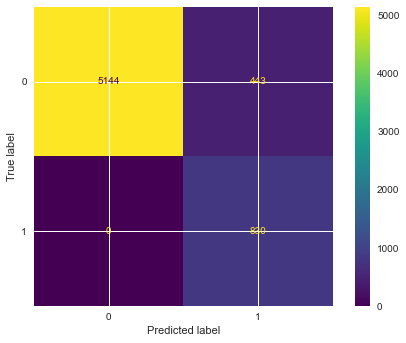

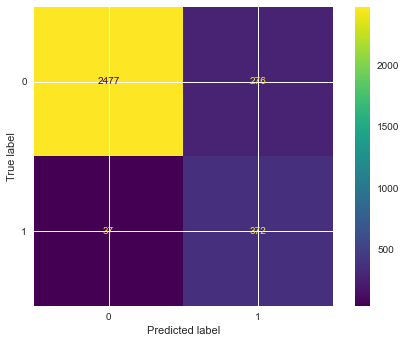

In [140]:
for i, item in enumerate([(X_train_nl, y_train_nl), (X_test_nl, y_test_nl)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(rf_best_params2, item[0], item[1], plot_cf=True)
    print('')

### Gradient Boosting

#### Test SKLearn GradientBoostingClassifier

- First impression is it doesn't actually score all that much better than the logistic regression
- Will try XG Boost then do a grid search

In [86]:
simple_gb = GradientBoostingClassifier(random_state=42)

simple_gb.fit(X_train_nl, y_train_nl)

gb_output = cross_validate(simple_gb, X_train_nl, y_train_nl, cv=5)

Train results
Accuracy: 0.9330
Precision: 0.7558
Recall: 0.7120
F1 Score: 0.7333
ROC: 0.9738

Test results
Accuracy: 0.9146
Precision: 0.6805
Recall: 0.6406
F1 Score: 0.6599
ROC: 0.9610



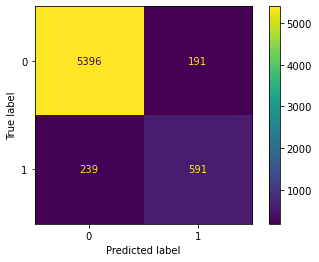

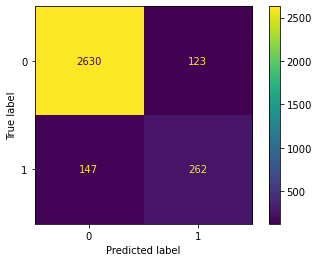

In [87]:
for i, item in enumerate([(X_train_nl, y_train_nl), (X_test_nl, y_test_nl)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(simple_gb, item[0], item[1], plot_cf=True)
    print('')

#### XG Boost
- Seems to be overfitting on training data
- Will try grid search to see if we can balance train and test results
- Class weights is remaining thing to test to see if we can reign in class imbalance problems

In [88]:
simple_xgb = XGBClassifier(random_state=42)

simple_xgb.fit(X_train_nl, y_train_nl)

xgb_output = cross_validate(simple_xgb, X_train_nl, y_train_nl, cv=5)

xgb_output['test_score']

array([0.90031153, 0.92445483, 0.90646921, 0.90646921, 0.89711613])

Train results
Accuracy: 0.9981
Precision: 0.9928
Recall: 0.9928
F1 Score: 0.9928
ROC: nan

Test results
Accuracy: 0.9111
Precision: 0.6608
Recall: 0.6430
F1 Score: 0.6518
ROC: nan



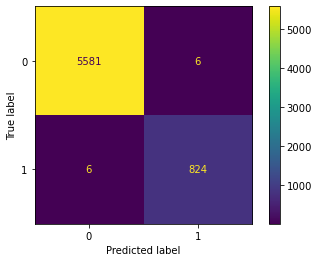

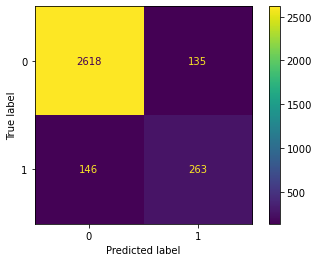

In [89]:
for i, item in enumerate([(X_train_nl, y_train_nl), (X_test_nl, y_test_nl)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(simple_xgb, item[0], item[1], plot_cf=True)
    print('')

In [350]:
# Set up parameters for the XGBoost

xgb_clf = XGBClassifier(random_state=42)

xgb_param_grid = {
'learning_rate': [0.001, 0.01, 0.1],
'n_estimators': [10, 100, 1000],
'subsample': [0.3, 0.5, 0.7],
'max_depth': [3, 5, 7, 9, 11, 15]
}

In [351]:
xgb_grid_search = GridSearchCV(xgb_clf, xgb_param_grid, return_train_score=True, cv=5)

# Fit to the data
xgb_grid_search.fit(X_train_nl, y_train_nl)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

In [354]:
xgb_grid_search.best_params_

{'learning_rate': 0.001,
 'max_depth': 9,
 'n_estimators': 1000,
 'subsample': 0.7}

In [90]:
xgb_best_params = XGBClassifier(random_state=42, learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=0.5)

xgb_best_params.fit(X_train_nl, y_train_nl)

xgb_output2 = cross_validate(xgb_best_params, X_train_nl, y_train_nl, cv=5)

xgb_output2['test_score']

array([0.91199377, 0.9182243 , 0.91582229, 0.91426345, 0.90179267])

Train results
Accuracy: 0.9559
Precision: 0.8307
Recall: 0.8277
F1 Score: 0.8292
ROC: nan

Test results
Accuracy: 0.9146
Precision: 0.6759
Recall: 0.6528
F1 Score: 0.6642
ROC: nan



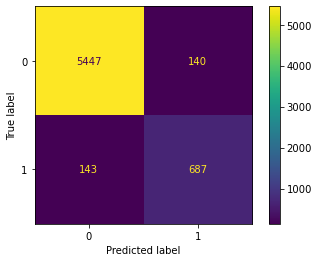

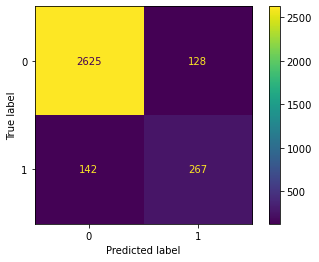

In [91]:
for i, item in enumerate([(X_train_nl, y_train_nl), (X_test_nl, y_test_nl)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(xgb_best_params, item[0], item[1], plot_cf=True)
    print('')

#### XGBoost: Scaled Position Weights
- Reduces falase negatives, but accuracy suffers

In [112]:
not_threatened = y_train_nl.value_counts()[0]
threatened = y_train_nl.value_counts()[1]

pos_weight = not_threatened / threatened

In [116]:
xgb_scaled = XGBClassifier(random_state=42, learning_rate=0.001, max_depth=9, n_estimators=1000, 
                                subsample=0.5, scale_pos_weight=pos_weight)

xgb_scaled.fit(X_train_nl, y_train_nl)

xgb_output3 = cross_validate(xgb_scaled, X_train_nl, y_train_nl, cv=5)

xgb_output3['test_score']

array([0.86370717, 0.90031153, 0.88074825, 0.88698363, 0.88152767])

Train results
Accuracy: 0.9051
Precision: 0.5773
Recall: 0.9940
F1 Score: 0.7304
ROC: nan

Test results
Accuracy: 0.8950
Precision: 0.5557
Recall: 0.9389
F1 Score: 0.6982
ROC: nan



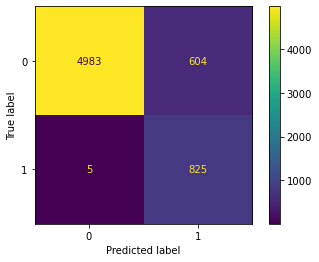

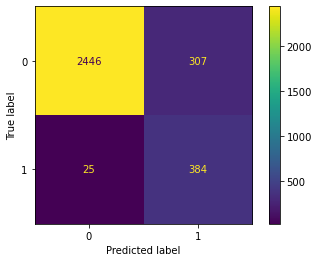

In [117]:
for i, item in enumerate([(X_train_nl, y_train_nl), (X_test_nl, y_test_nl)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(xgb_scaled, item[0], item[1], plot_cf=True)
    print('')

#### XGBoost: Polynomial transformation

- Delete for final notebook

In [373]:
# Polynomial transformation

pf = PolynomialFeatures()

X_train_pf = pf.fit_transform(X_train_nl)
X_test_pf = pf.transform(X_test_nl)

In [367]:
xgb_pf = XGBClassifier(random_state=42, learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=0.5)

xgb_pf.fit(X_train_pf, y_train)

xgb_output3 = cross_validate(xgb_pf, X_train_pf, y_train, cv=5)

xgb_output3['test_score']

array([0.907393  , 0.91906615, 0.91050584, 0.92062257, 0.92056075])

Train results
Accuracy: 0.9633
Precision: 0.8712
Recall: 0.8398
F1 Score: 0.8552

Test results
Accuracy: 0.9100
Precision: 0.6558
Recall: 0.6381
F1 Score: 0.6468



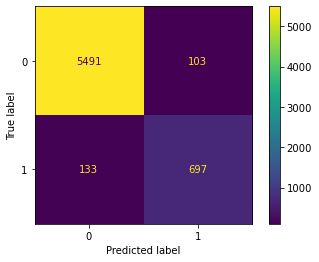

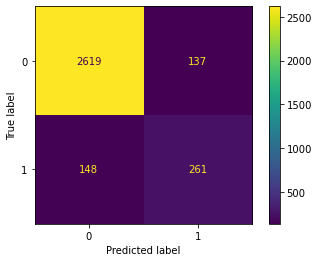

In [368]:
for i, item in enumerate([(X_train_pf, y_train), (X_test_pf, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(xgb_pf, item[0], item[1], plot_cf=True)
    print('')

## Deck Visualizations



In [133]:
# Threatened species examples

threatened = df_clean[df_clean['threatened'] == 1]
nt = df_clean[df_clean['threatened'] == 0]

In [136]:
list(threatened['English'])

['Southern Brown Kiwi',
 'Great Spotted Kiwi',
 'Grey Tinamou',
 'Black Tinamou',
 'Choco Tinamou',
 "Taczanowski's Tinamou",
 'Lesser Nothura',
 'Dwarf Tinamou',
 'Rufous-headed Chachalaca',
 'Baudo Guan',
 'Cauca Guan',
 'White-winged Guan',
 'White-crested Guan',
 'Chestnut-bellied Guan',
 'White-browed Guan',
 'Trinidad Piping-guan',
 'Black-fronted Piping-guan',
 'Highland Guan',
 'Horned Guan',
 'Helmeted Curassow',
 'Horned Curassow',
 'Great Curassow',
 'Blue-billed Curassow',
 'Black Curassow',
 'Wattled Curassow',
 'Bare-faced Curassow',
 'Red-billed Curassow',
 'Maleo',
 'Malleefowl',
 'Swamp Francolin',
 'Djibouti Francolin',
 'Mount Cameroon Francolin',
 "Swierstra's Francolin",
 'Black Partridge',
 'Manipur Bush-quail',
 'Udzungwa Forest-partridge',
 'Chestnut-breasted Partridge',
 'Sichuan Partridge',
 'White-faced Partridge',
 'Hainan Partridge',
 'Chestnut-necklaced Partridge',
 'Western Tragopan',
 "Blyth's Tragopan",
 "Cabot's Tragopan",
 "Sclater's Monal",
 'Chinese

<ipython-input-287-80422db0d962>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y, fontsize=16, color='black')


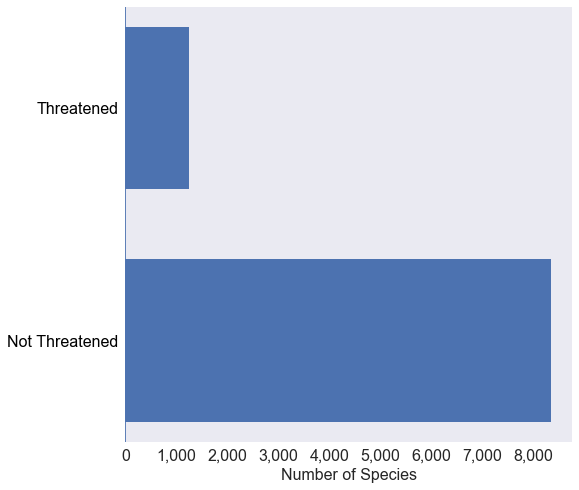

In [287]:
# Threatened species distribution

fig, ax = plt.subplots(figsize=(8,8))

threatened_vc = df_clean['threatened'].value_counts()
y = ['Not Threatened', 'Threatened']

ax.barh(y = y, width = threatened_vc, height=0.7);
ax.set_yticklabels(y, fontsize=16, color='black')
ax.axvline(x=0, ymin=0, ymax=1)
ax.set_xlabel('Number of Species', fontsize=16)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(fontsize=16)

plt.yticks(rotation = 0, wrap=True)
plt.grid(False);

In [277]:
# Region value counts

region_dict = {}

for region in regions:
    region_dict[region] = int(df_clean[region].sum())

In [281]:
threats_dict = {}

for threat in threats:
    threats_dict[threat] = int(df_clean[threat].sum())
    
sorted_threats = sorted(threats_dict.items(), key=lambda kv: kv[1], reverse=True)

In [283]:
df_clean[df_clean['num_threats'] == 0].shape

(6597, 94)

In [282]:
sorted_threats

[('biological_threat', 1984),
 ('agriculture_threat', 1865),
 ('climate_change_threat', 1087),
 ('invasive_threat', 877),
 ('natural_systems_threat', 733),
 ('res_comm_dev_threat', 603),
 ('energy_mining_threat', 451),
 ('pollution_threat', 449),
 ('transportation_threat', 370),
 ('human_intrusions_threat', 324),
 ('geological_threat', 41)]

In [156]:
# Threats summary

df_clean[df_clean['agriculture_threat'] == 1]['threatened'].value_counts()

1    968
0    897
Name: threatened, dtype: int64

In [197]:
list(reversed(range(1,11)))

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [200]:
threat_sorted

[3, 14, 22, 56, 131, 266, 476, 681, 664, 669]

In [272]:
threats

['agriculture_threat',
 'biological_threat',
 'climate_change_threat',
 'energy_mining_threat',
 'geological_threat',
 'human_intrusions_threat',
 'natural_systems_threat',
 'pollution_threat',
 'res_comm_dev_threat',
 'transportation_threat',
 'invasive_threat']

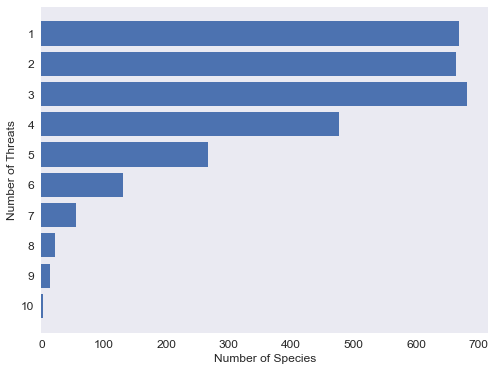

In [202]:
# Threatened species distribution

fig, ax = plt.subplots(figsize=(8,6))

threat_distribution = df_clean['num_threats'].value_counts().sort_index().iloc[1:]
threat_sorted = list(reversed(threat_distribution.values))
y = [str(x) for x in list(reversed(range(1,11)))]

ax.barh(y = y, width = threat_sorted);
ax.set_xlabel('Number of Species', fontsize=12)
ax.set_ylabel('Number of Threats', fontsize=12)
plt.xticks(fontsize=12)

plt.yticks(fontsize=12)
plt.grid(False);

In [ ]:
# Distribution by threats
df_threats = df_clean[threats + ['threatened']]

In [212]:
df_clean[df_clean['num_threats'] == 10][['English']]



,English
2346,Black-necked Crane
2518,Black-tailed Godwit
3251,Little Penguin


In [210]:
nine_threats = df_clean[df_clean['num_threats'] == 9][['English'] + ['threatened'] + habitats + ['num_habitats']]

nine_threats

,English,threatened,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland,num_habitats
2336,Sarus Crane,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,2.00
2342,Wattled Crane,1,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,3.00
2520,Bar-tailed Godwit,0,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
2527,Eurasian Curlew,0,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,3.00
2602,Eurasian Oystercatcher,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2753,River Tern,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2852,Cape Vulture,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,4.00
3055,Lanner Falcon,0,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,3.00
3191,Southern Bald Ibis,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3206,Shoebill,1,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,3.00


In [211]:
harrier = df_clean[df_clean['English'] == 'Reunion Harrier']

harrier

,SpecID,PassNonPass,IOCOrder,BLFamilyLatin,BLFamilyEnglish,BLFamSequID,Taxo,Scientific,English,Diet-Inv,Diet-Vend,Diet-Vect,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,Diet-5Cat,Diet-Source,Diet-Certainty,Diet-EnteredBy,ForStrat-watbelowsurf,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,PelagicSpecialist,ForStrat-Source,ForStrat-SpecLevel,ForStrat-EnteredBy,Nocturnal,BodyMass-Value,BodyMass-Source,BodyMass-SpecLevel,BodyMass-Comment,Record-Comment,Family,Global IUCN Red List Category,endemic_breeding,migratory,africa,antarctica,asia,australasia,caribbean,central_amer,central_asia,europe,high_seas,mid_east,north_amer,oceania,south_amer,agriculture_threat,biological_threat,climate_change_threat,energy_mining_threat,geological_threat,human_intrusions_threat,natural_systems_threat,pollution_threat,res_comm_dev_threat,transportation_threat,invasive_threat,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland,breeding_range,threatened,num_threats,num_habitats,num_regions,marine_hab,marine_x_pollution,marine_x_climatechg,ag+habitat,inv+habitat,all+habitat
8835,4691.00,Nonpasseriformes,Accipitriformes,Accipitridae,"Osprey, kites, hawks and eagles",36.00,BL3,Circus maillardi,Reunion Harrier,10.00,50.00,40.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,VertFishScav,Ref_2,A,Jennifer,0.00,0.00,60.00,40.00,0.00,0.00,0.00,0.00,Ref_2,1.00,Other,0.00,663.60,Dunning08,1.00,NaN,NaN,"Accipitridae (Hawks, Eagles)",EN,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,AF,1,9.00,1.00,1.00,0,0.00,0.00,1,1,0


In [288]:
df_clean[df_clean['num_threats'] > 1].shape

(2313, 94)

In [242]:
# Agriculture and invasive species

threatened = df_clean[df_clean['threatened'] == 1]

ag_inv = threatened[(threatened['agriculture_threat'] == 1) & (threatened['invasive_threat'] == 1)]

list(ag_inv['English'])

['Lesser Nothura',
 'Dwarf Tinamou',
 'Horned Guan',
 'Great Curassow',
 'Malleefowl',
 'Udzungwa Forest-partridge',
 "Cabot's Tragopan",
 'White-breasted Guineafowl',
 'Gorgeted Wood-quail',
 'White-headed Duck',
 'Maccoa Duck',
 'Swan Goose',
 'Lesser White-fronted Goose',
 'Hawaiian Goose',
 'Blue Duck',
 "Salvadori's Teal",
 "Meller's Duck",
 'Madagascar Teal',
 'Common Pochard',
 'Madagascar Pochard',
 "Baer's Pochard",
 'Buff-breasted Buttonquail',
 "Fernandina's Flicker",
 'Okinawa Woodpecker',
 'Zambian Barbet',
 'Narcondam Hornbill',
 'Southern Ground-hornbill',
 'Scaly Ground-roller',
 'Long-tailed Ground-roller',
 'Keel-billed Motmot',
 'Tuamotu Kingfisher',
 'Green-billed Coucal',
 'Yellow-crested Cockatoo',
 'Philippine Cockatoo',
 'Red-and-blue Lory',
 'Rimatara Lorikeet',
 'Ultramarine Lorikeet',
 'Palm Lorikeet',
 'New Caledonian Lorikeet',
 'Red-throated Lorikeet',
 'Kea',
 'Golden-shouldered Parrot',
 'Orange-bellied Parrot',
 'Swift Parrot',
 'Night Parrot',
 'Black-

In [216]:
ag_inv.describe()

,SpecID,BLFamSequID,Diet-Inv,Diet-Vend,Diet-Vect,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,ForStrat-watbelowsurf,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,PelagicSpecialist,ForStrat-SpecLevel,Nocturnal,BodyMass-Value,BodyMass-SpecLevel,endemic_breeding,migratory,africa,antarctica,asia,australasia,caribbean,central_amer,central_asia,europe,high_seas,mid_east,north_amer,oceania,south_amer,agriculture_threat,biological_threat,climate_change_threat,energy_mining_threat,geological_threat,human_intrusions_threat,natural_systems_threat,pollution_threat,res_comm_dev_threat,transportation_threat,invasive_threat,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland,threatened,num_threats,num_habitats,num_regions,marine_hab,marine_x_pollution,marine_x_climatechg,ag+habitat,inv+habitat,all+habitat
count,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00
mean,7399.21,98.01,46.31,2.75,4.25,5.23,0.42,2.35,13.33,5.00,12.84,7.52,4.58,9.15,43.71,16.99,15.62,9.52,0.39,0.03,0.97,0.03,604.15,0.84,0.65,0.18,0.27,0.00,0.22,0.16,0.08,0.02,0.04,0.04,0.00,0.04,0.12,0.08,0.14,1.00,0.72,0.50,0.17,0.03,0.24,0.40,0.26,0.33,0.18,1.00,0.03,0.36,0.00,0.03,0.53,0.19,0.00,0.06,0.04,0.04,0.00,0.05,0.13,0.29,0.16,1.00,4.83,1.91,1.21,0.08,0.03,0.03,0.16,0.16,0.00
std,5231.11,62.86,35.97,11.35,11.20,16.80,2.71,12.77,23.39,17.05,22.78,17.38,18.27,23.06,39.44,20.21,20.95,18.94,3.00,0.16,0.17,0.16,1432.61,0.36,0.48,0.38,0.45,0.00,0.41,0.36,0.26,0.15,0.19,0.19,0.00,0.19,0.33,0.27,0.34,0.00,0.45,0.50,0.38,0.17,0.42,0.49,0.44,0.47,0.38,0.00,0.16,0.48,0.06,0.17,0.50,0.39,0.00,0.23,0.20,0.20,0.06,0.22,0.33,0.45,0.36,0.00,1.62,1.52,0.74,0.27,0.16,0.18,0.37,0.37,0.00
min,108.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3511.25,42.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,28.64,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,4.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,5601.50,73.00,40.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,40.00,10.00,0.00,0.00,0.00,0.00,1.00,0.00,76.50,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,5.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,11031.25,161.00,80.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00,20.00,0.00,0.00,0.00,80.00,30.00,30.00,10.00,0.00,0.00,1.00,0.00,387.29,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,6.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
max,20094.00,192.00,100.00,90.00,70.00,90.00,30.00,100.00,100

In [219]:
ag_threat_vc = df_clean[df_clean['agriculture_threat'] == 1]['threatened'].value_counts(normalize=True)
inv_threat_vc = df_clean[df_clean['invasive_threat'] == 1]['threatened'].value_counts(normalize=True)
overall_vc = df_clean['threatened'].value_counts(normalize=True)

In [229]:
threat_summary = pd.DataFrame([ag_threat_vc,inv_threat_vc, overall_vc], index=['ag_threat', 'inv_threat', 'overall'])
threat_summary

,0,1
ag_threat,0.48,0.52
inv_threat,0.42,0.58
overall,0.87,0.13


In [232]:
list(threat_summary.iloc[:,0])

[0.4809651474530831, 0.4218928164196123, 0.8706545568430942]

<ipython-input-298-768fcdf2eb3d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=12)


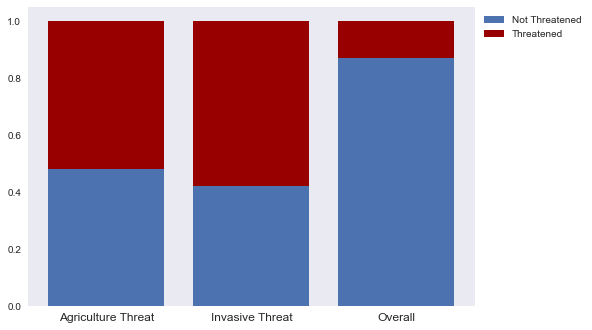

In [298]:
fig, ax = plt.subplots()

labels = ['Agriculture Threat', 'Invasive Threat', 'Overall']
not_threatened = list(threat_summary.iloc[:,0])
threatened = list(threat_summary.iloc[:,1])

ax.bar(labels, not_threatened, label='Not Threatened')
ax.bar(labels, threatened, label='Threatened', bottom=not_threatened, color=('#980000'))
ax.set_xticklabels(labels, fontsize=12)
ax.legend(bbox_to_anchor=(1,1))
plt.grid(False);

In [296]:
list(df_clean[(df_clean['agriculture_threat'] == 1) & (df_clean['invasive_threat'] == 1) & 
              (df_clean['threatened'] == 1) & (df_clean['num_threats'] == 2)]['English'])

['Black-and-white Monjita',
 'White-tailed Shrike-tyrant',
 'Stitchbird',
 'Painted Honeyeater',
 'Yellowhead',
 'Manus Fantail',
 'Golden Swallow',
 "Worthen's Sparrow",
 'St Lucia Black Finch',
 'Martinique Oriole',
 'Northern Brown Kiwi']

In [292]:
list(df_clean[(df_clean['agriculture_threat'] == 1) & (df_clean['invasive_threat'] == 1) & 
              (df_clean['threatened'] == 1) & (df_clean['num_threats'] == 2)]['English'])

['Black-and-white Monjita',
 'White-tailed Shrike-tyrant',
 'Stitchbird',
 'Painted Honeyeater',
 'Yellowhead',
 'Manus Fantail',
 'Golden Swallow',
 "Worthen's Sparrow",
 'St Lucia Black Finch',
 'Martinique Oriole',
 'Northern Brown Kiwi']

In [290]:
# 

list(df_clean[(df_clean['agriculture_threat'] == 1) & (df_clean['invasive_threat'] == 1) & 
              (df_clean['threatened'] == 1) & (df_clean)]['English'])

['Lesser Nothura',
 'Dwarf Tinamou',
 'Horned Guan',
 'Great Curassow',
 'Malleefowl',
 'Udzungwa Forest-partridge',
 "Cabot's Tragopan",
 'White-breasted Guineafowl',
 'Gorgeted Wood-quail',
 'White-headed Duck',
 'Maccoa Duck',
 'Swan Goose',
 'Lesser White-fronted Goose',
 'Hawaiian Goose',
 'Blue Duck',
 "Salvadori's Teal",
 "Meller's Duck",
 'Madagascar Teal',
 'Common Pochard',
 'Madagascar Pochard',
 "Baer's Pochard",
 'Buff-breasted Buttonquail',
 "Fernandina's Flicker",
 'Okinawa Woodpecker',
 'Zambian Barbet',
 'Narcondam Hornbill',
 'Southern Ground-hornbill',
 'Scaly Ground-roller',
 'Long-tailed Ground-roller',
 'Keel-billed Motmot',
 'Tuamotu Kingfisher',
 'Green-billed Coucal',
 'Yellow-crested Cockatoo',
 'Philippine Cockatoo',
 'Red-and-blue Lory',
 'Rimatara Lorikeet',
 'Ultramarine Lorikeet',
 'Palm Lorikeet',
 'New Caledonian Lorikeet',
 'Red-throated Lorikeet',
 'Kea',
 'Golden-shouldered Parrot',
 'Orange-bellied Parrot',
 'Swift Parrot',
 'Night Parrot',
 'Black-

In [305]:
list(df_clean[(df_clean['high_seas'] == 1) & (df_clean['threatened'] == 1)]['English'])

['Macaroni Penguin',
 'Chatham Petrel',
 "Cook's Petrel",
 "Pycroft's Petrel",
 'Trindade Petrel',
 "Barau's Petrel",
 'Providence Petrel',
 "Zino's Petrel",
 'White-chinned Petrel',
 'Wandering Albatross',
 'Amsterdam Albatross',
 'Waved Albatross',
 'Grey-headed Albatross',
 'Atlantic Yellow-nosed Albatross',
 'Sooty Albatross',
 'Spectacled Petrel',
 'Antipodean Albatross',
 'Tristan Albatross',
 'Indian Yellow-nosed Albatross',
 "Gould's Petrel",
 "Parkinson's Petrel"]

In [306]:
df_clean[df_clean['English'] == 'Wandering Albatross']

,SpecID,PassNonPass,IOCOrder,BLFamilyLatin,BLFamilyEnglish,BLFamSequID,Taxo,Scientific,English,Diet-Inv,Diet-Vend,Diet-Vect,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,Diet-5Cat,Diet-Source,Diet-Certainty,Diet-EnteredBy,ForStrat-watbelowsurf,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,PelagicSpecialist,ForStrat-Source,ForStrat-SpecLevel,ForStrat-EnteredBy,Nocturnal,BodyMass-Value,BodyMass-Source,BodyMass-SpecLevel,BodyMass-Comment,Record-Comment,Family,Global IUCN Red List Category,endemic_breeding,migratory,africa,antarctica,asia,australasia,caribbean,central_amer,central_asia,europe,high_seas,mid_east,north_amer,oceania,south_amer,agriculture_threat,biological_threat,climate_change_threat,energy_mining_threat,geological_threat,human_intrusions_threat,natural_systems_threat,pollution_threat,res_comm_dev_threat,transportation_threat,invasive_threat,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland,breeding_range,threatened,num_threats,num_habitats,num_regions,marine_hab,marine_x_pollution,marine_x_climatechg,ag+habitat,inv+habitat,all+habitat
3325,5575.00,Nonpasseriformes,Procellariiformes,Diomedeidae,Albatrosses,17.00,BL3,Diomedea exulans,Wandering Albatross,90.00,0.00,0.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,Invertebrate,Ref_1,A,Jennifer,0.00,100.00,0.00,0.00,0.00,0.00,0.00,1.00,Ref_1,1.00,Jessica,0.00,6961.29,Dunning08,1.00,NaN,NaN,Diomedeidae (Albatrosses),VU,0.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,SO,1,4.00,0.00,5.00,0,0.00,0.00,0,0,0


In [263]:
# Show threatened incidence in oceania and the high seas

oceania_vc = df_clean[df_clean['oceania'] == 1]['threatened'].value_counts(normalize=True)
high_seas_vc = df_clean[df_clean['high_seas'] == 1]['threatened'].value_counts(normalize=True)
europe_vc = df_clean[df_clean['europe'] == 1]['threatened'].value_counts(normalize=True)

In [264]:
region_summary = pd.DataFrame([oceania_vc,high_seas_vc, europe_vc, overall_vc], index=['Oceania', 'High Seas', 
                                                                                       'Europe', 'Overall'])
region_summary

,0,1
Oceania,0.77,0.23
High Seas,0.45,0.55
Europe,0.93,0.07
Overall,0.87,0.13


<ipython-input-299-1c964916b871>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=12)


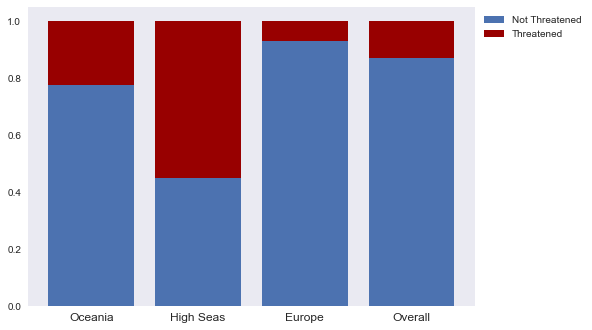

In [299]:
fig, ax = plt.subplots()

labels = ['Oceania', 'High Seas', 'Europe', 'Overall']
not_threatened2 = list(region_summary.iloc[:,0])
threatened2 = list(region_summary.iloc[:,1])

ax.bar(labels, not_threatened2, label='Not Threatened')
ax.bar(labels, threatened2, label='Threatened', bottom=not_threatened2, color=('#980000'))
ax.legend(bbox_to_anchor=(1,1))
ax.set_xticklabels(labels, fontsize=12)
plt.grid(False);

In [253]:
# Endemic breeding

endemic_breeding = df_clean[df_clean['endemic_breeding'] == 1]
endemic_breeding.describe()

,SpecID,BLFamSequID,Diet-Inv,Diet-Vend,Diet-Vect,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,ForStrat-watbelowsurf,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,PelagicSpecialist,ForStrat-SpecLevel,Nocturnal,BodyMass-Value,BodyMass-SpecLevel,endemic_breeding,migratory,africa,antarctica,asia,australasia,caribbean,central_amer,central_asia,europe,high_seas,mid_east,north_amer,oceania,south_amer,agriculture_threat,biological_threat,climate_change_threat,energy_mining_threat,geological_threat,human_intrusions_threat,natural_systems_threat,pollution_threat,res_comm_dev_threat,transportation_threat,invasive_threat,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland,threatened,num_threats,num_habitats,num_regions,marine_hab,marine_x_pollution,marine_x_climatechg,ag+habitat,inv+habitat,all+habitat
count,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00,2464.00
mean,7748.89,114.10,54.80,1.75,1.89,1.45,0.24,0.24,17.45,7.68,10.45,4.03,1.54,3.03,30.63,25.01,25.26,13.07,1.42,0.03,0.94,0.04,187.98,0.81,1.00,0.05,0.12,0.00,0.30,0.23,0.04,0.01,0.00,0.01,0.01,0.00,0.07,0.05,0.21,0.38,0.38,0.24,0.08,0.01,0.04,0.13,0.04,0.12,0.07,0.19,0.02,0.39,0.00,0.01,0.60,0.14,0.00,0.03,0.02,0.03,0.01,0.04,0.16,0.31,0.15,0.32,1.68,1.92,1.04,0.05,0.00,0.01,0.08,0.07,0.00
std,4948.86,52.43,37.62,10.07,7.70,8.67,2.49,2.12,27.97,21.08,21.05,12.12,10.82,14.76,37.53,25.54,25.80,21.55,8.71,0.16,0.24,0.19,557.64,0.39,0.00,0.21,0.33,0.05,0.46,0.42,0.19,0.10,0.03,0.08,0.08,0.06,0.25,0.21,0.40,0.49,0.48,0.43,0.28,0.10,0.20,0.34,0.20,0.33,0.25,0.39,0.15,0.49,0.05,0.11,0.49,0.35,0.00,0.17,0.16,0.16,0.11,0.19,0.36,0.46,0.36,0.46,1.84,1.52,0.30,0.21,0.06,0.09,0.27,0.25,0.00
min,55.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.20,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3534.75,68.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,15.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,7495.50,117.00,50.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00,20.00,20.00,0.00,0.00,0.00,1.00,0.00,37.16,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,10814.25,163.00,100.00,0.00,0.00,0.00,0.00,0.00,30.00,0.00,10.00,0.00,0.00,0.00,60.00,40.00,40.00,20.00,0.00,0.00,1.00,0.00,123.28,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,3.00,3.00,1.00,0.00,0.00,0.00,0

In [267]:
endemic_breeding_vc = df_clean[df_clean['endemic_breeding'] == 1]['threatened'].value_counts(normalize=True)

endemic_summary = pd.DataFrame([endemic_breeding_vc, overall_vc], index=['Endemic_breeding', 'Overall'])
                                                                             
endemic_summary

,0,1
Endemic_breeding,0.68,0.32
Overall,0.87,0.13


<ipython-input-300-71c848640f53>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=12)


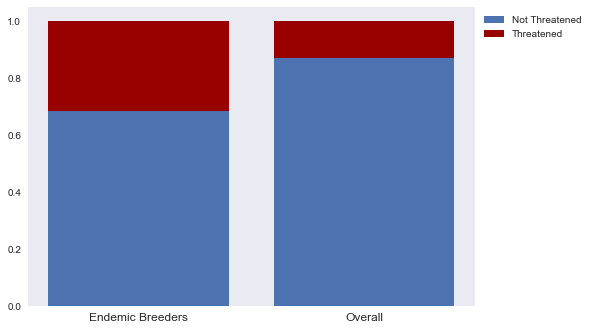

In [300]:
fig, ax = plt.subplots()

labels = ['Endemic Breeders', 'Overall']
not_threatened3 = list(endemic_summary.iloc[:,0])
threatened3 = list(endemic_summary.iloc[:,1])

ax.bar(labels, not_threatened3, label='Not Threatened')
ax.bar(labels, threatened3, label='Threatened', bottom=not_threatened3, color=('#980000'))
ax.legend(bbox_to_anchor=(1,1))
ax.set_xticklabels(labels, fontsize=12)
plt.grid(False);

In [302]:
endemic_breeding_threatened[endemic_breeding_threatened['English'] == 'Saltmarsh Sparrow']

,SpecID,PassNonPass,IOCOrder,BLFamilyLatin,BLFamilyEnglish,BLFamSequID,Taxo,Scientific,English,Diet-Inv,Diet-Vend,Diet-Vect,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,Diet-5Cat,Diet-Source,Diet-Certainty,Diet-EnteredBy,ForStrat-watbelowsurf,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,PelagicSpecialist,ForStrat-Source,ForStrat-SpecLevel,ForStrat-EnteredBy,Nocturnal,BodyMass-Value,BodyMass-Source,BodyMass-SpecLevel,BodyMass-Comment,Record-Comment,Family,Global IUCN Red List Category,endemic_breeding,migratory,africa,antarctica,asia,australasia,caribbean,central_amer,central_asia,europe,high_seas,mid_east,north_amer,oceania,south_amer,agriculture_threat,biological_threat,climate_change_threat,energy_mining_threat,geological_threat,human_intrusions_threat,natural_systems_threat,pollution_threat,res_comm_dev_threat,transportation_threat,invasive_threat,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland,breeding_range,threatened,num_threats,num_habitats,num_regions,marine_hab,marine_x_pollution,marine_x_climatechg,ag+habitat,inv+habitat,all+habitat
7493,12550.00,Passeriformes,Passeriformes,Emberizidae,"Buntings, American sparrows and allies",192.00,BL3,Ammodramus caudacutus,Saltmarsh Sparrow,80.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00,Invertebrate,Ref_22,A,Jennifer,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,Ref_31,1.00,Christian,0.00,19.19,Dunning08,1.00,NaN,NaN,Passerellidae (New World sparrows),EN,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,1,6.00,0.00,1.00,0,0.00,0.00,0,0,0


In [256]:
endemic_breeding_threatened = endemic_breeding[endemic_breeding['threatened'] == 1]
list(endemic_breeding_threatened['English'])

['Southern Brown Kiwi',
 'Great Spotted Kiwi',
 'Cauca Guan',
 'White-winged Guan',
 'White-crested Guan',
 'Chestnut-bellied Guan',
 'White-browed Guan',
 'Trinidad Piping-guan',
 'Horned Curassow',
 'Blue-billed Curassow',
 'Red-billed Curassow',
 'Maleo',
 'Malleefowl',
 'Djibouti Francolin',
 'Mount Cameroon Francolin',
 "Swierstra's Francolin",
 'Manipur Bush-quail',
 'Udzungwa Forest-partridge',
 'Sichuan Partridge',
 'White-faced Partridge',
 'Hainan Partridge',
 "Cabot's Tragopan",
 'Chinese Monal',
 'Brown Eared-pheasant',
 "Reeves's Pheasant",
 'Palawan Peacock-pheasant',
 'Congo Peafowl',
 'Lesser Prairie-chicken',
 'Bearded Wood-partridge',
 'Gorgeted Wood-quail',
 'Hawaiian Goose',
 'Blue-winged Goose',
 'Blue Duck',
 'White-headed Steamerduck',
 'Philippine Duck',
 "Meller's Duck",
 'Madagascar Teal',
 'Madagascar Pochard',
 'Buff-breasted Buttonquail',
 'Sumba Buttonquail',
 'Speckle-chested Piculet',
 'Varzea Piculet',
 "Fernandina's Flicker",
 'Andaman Woodpecker',
 'O